In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("data2021.student.csv", delimiter=',', header=[0])  # No attributes

print(data)

        ID  Class  C1   C2  C3    C4  C5  C6  C7  C8  ...  C23 C24 C25 C26  \
0        1    1.0  53  yes  V5  11.0  V2  V1  V1  V3  ...    1  V3  11  V2   
1        2    0.0  35  yes  V3  11.0  V7  V1  V1  V1  ...    2  V1  11  V4   
2        3    1.0  40  yes  V5  18.0  V2  V1  V2  V3  ...    1  V2  18  V3   
3        4    0.0  28  yes  V3  14.0  V7  V1  V1  V4  ...    1  V1  14  V2   
4        5    0.0  40  yes  V3  11.0  V1  V1  V4  V1  ...    1  V1  11  V3   
...    ...    ...  ..  ...  ..   ...  ..  ..  ..  ..  ...  ...  ..  ..  ..   
1095  1096    NaN  31  yes  V3  48.0  V3  V1  V1  V4  ...    1  V2  48  V2   
1096  1097    NaN  39  yes  V5  22.0  V3  V3  V4  V4  ...    1  V2  22  V2   
1097  1098    NaN  23  yes  V3  17.0  V2  V1  V1  V1  ...    2  V1  17  V4   
1098  1099    NaN  25   no  V2   5.0  V3  V1  V2  V1  ...    1  V2   5  V2   
1099  1100    NaN  34  yes  V3   7.0  V3  V1  V2  V1  ...    1  V2   7  V2   

     C27 C28  C29  C30   C31 C32  
0      4  V3  1.0    T  7865

# Data Preparation

In [3]:
# Class obviously should be categorical
data["Class"] = data["Class"].astype('category')

# Convert all attributes with data type 'object', representing non-numeric
# strings, to categorical
converting = []
for att in data:
    if data[att].dtype.name == 'object':
        data[att] = data[att].astype('category')
        converting.append(att)

print("Explicitly converted the following non-numeric attributes to categorical:")
print(converting, '\n')

Explicitly converted the following non-numeric attributes to categorical:
['C2', 'C3', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'C18', 'C21', 'C22', 'C24', 'C26', 'C28', 'C30'] 



In [4]:
# Drop the ID attribute, because it doesn't contribute anything to the classification; there is no point to including it
data.drop(['ID'], axis=1, inplace=True)
print("Dropped the ['ID'] attribute\n")

Dropped the ['ID'] attribute



In [5]:
# Remove all attributes with missing values more than the threshold
missing_threshold = 0.8
dropping = []
for att in data:
    missing = data[att].isnull().sum() / data[att].size
    if missing >= missing_threshold and att != 'Class':
        dropping.append(att)

print("Dropping the following attributes (due to too many missing values):")
print(dropping, '\n')
data.drop(dropping, axis=1, inplace=True)

Dropping the following attributes (due to too many missing values):
['C11', 'C32'] 



In [6]:
# Convert numeric attributes to categorical when they are likely to be so
unique_threshold = 10
converting = []
for att in data:
    if data[att].dtype.name != 'category':
        if data[att].nunique() <= 10:
            data[att] = data[att].astype('category')
            converting.append(att)

print("Converted the following numeric attributes to categorical (due to few unique values):")
print(converting, '\n')

Converted the following numeric attributes to categorical (due to few unique values):
['C15', 'C17', 'C20', 'C23', 'C27', 'C29'] 



In [7]:
# Replace all numeric and nominal attributes with missing values less than the threshold with the global mean and mode respectively
impute_threshold = 0.05  # Note that this, as well as the previous step, covers all missing values for this dataset
imputed = []
for att in data:
    missing = data[att].isnull().sum() / data[att].size
    if missing < impute_threshold and missing != 0 and att != 'Class':
        # Replace values with the mode for nominal attributes
        if data[att].dtype.name == 'category':
            data[att].fillna(data[att].mode()[0], inplace=True)
        # Replace values with the mean for numeric attributes
        else:
            data[att].fillna(data[att].mean(), inplace=True)
        imputed.append(att)

print("Imputed mean (for numeric) and mode (for nominal) values for the following attributes (due to missing values):")
print(imputed, '\n')

Imputed mean (for numeric) and mode (for nominal) values for the following attributes (due to missing values):
['C3', 'C4', 'C13', 'C29'] 



In [8]:
# Scaling all numeric attributes to the range [0,1] (normalisation)
data_numeric = data.select_dtypes(include='number')
scaled_data_numeric = MinMaxScaler().fit_transform(data_numeric)
data[data_numeric.columns] = scaled_data_numeric

print("Scaled numeric data to range [0,1]\n")

Scaled numeric data to range [0,1]



In [9]:
# Remove all attributes with extremely low variance below the threshold
var_threshold = 0.0
dropping = []
for att in data:
    if data[att].dtype.name != 'category':
        var = data[att].var()
        if var <= var_threshold and att != 'Class':
            dropping.append(att)

print("Dropping the following numeric attributes (due to extremely low variance):")
print(dropping, '\n')
data.drop(dropping, axis=1, inplace=True)

Dropping the following numeric attributes (due to extremely low variance):
[] 



In [10]:
# This is done separately to the dropping attributes with low variance as in the case var_threshold > 0.0
dropping = []
for att in data:
    if data[att].dtype.name == 'category':
        if data[att].nunique() == 1:
            dropping.append(att)

print("Dropping the following categorical attributes (due to only having one unique value):")
print(dropping, '\n')
data.drop(dropping, axis=1, inplace=True)

Dropping the following categorical attributes (due to only having one unique value):
['C10', 'C15', 'C17', 'C30'] 



In [11]:
# Detect and delete all duplicate attributes, keeping the first found attribute
data_transposed = data.transpose()
data_transposed_is_duplicate = data_transposed.duplicated(subset=None, keep='first')
duplicate_cols_indices = np.where(data_transposed_is_duplicate == True)[0]
# Convert the tranpose 'row' indices, representing columns, to the relevant attribute names
duplicate_cols = data.columns[duplicate_cols_indices]

print("Dropping the following attributes (due to being duplicates):")
print(duplicate_cols, '\n')
data.drop(duplicate_cols, axis=1, inplace=True)

Dropping the following attributes (due to being duplicates):
Index(['C12', 'C26', 'C31'], dtype='object') 



In [12]:
# Detect and delete all duplicate instances, keeping the first found instance
data_is_duplicate = data.duplicated(subset=None, keep='first')
duplicate_rows = np.where(data_is_duplicate == True)[0]
data.drop(index=duplicate_rows, axis=0, inplace=True)

print("Dropping the following instances (due to being duplicates):")
print(duplicate_rows, '\n')

Dropping the following instances (due to being duplicates):
[900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917
 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935
 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953
 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971
 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989
 990 991 992 993 994 995 996 997 998 999] 



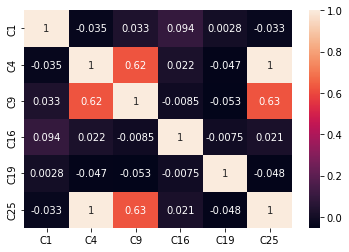

In [13]:
# Display a correlation matrix for numeric attributes
corr_matrix = data.corr()  # Using the 'pearson' method by default
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
# Remove highly correlated numeric attributes automatically
corr_threshold = 0.9
dropping = []
# Retrieve only the upper triangle of the matrix, not including the diagonal line of 1s, as the calc is symmetrical
corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
dropping = [att for att in corr_matrix_upper.columns if any(corr_matrix_upper[att] > corr_threshold)]

print("Dropping the following numeric attributes (due to being highly correlated with another attribute):")
print(dropping, '\n')
data.drop(dropping, axis=1, inplace=True)

Dropping the following numeric attributes (due to being highly correlated with another attribute):
['C25'] 



In [15]:
#TODO: correlation matrix for categorical attributes (cramer)

In [16]:
# AFTER IMPUTING/REMOVING MISSING
# AFTER SCALING

# SPLIT DATA INTO UNBALANCED TRAINING AND BALANCED (by shuffled numeric selection) VALIDATION

# before removing attributes?
# BEFORE OVERSAMPLING

In [17]:
y = data.pop('Class')  # Remove the Class attribute from the dataframe
y = y.to_numpy()

# Using one-hot encoding for categorical attributes, as the classification models don't take strings.
# Downside: adds extra 51 'attributes'
# Upside: does not assume that categories are ordinal, something we can't easily determine without
#         domain knowledge
data_encoded = pd.get_dummies(data)
x = data_encoded.to_numpy()

x_train = x[:-100]
x_test  = x[-100:]
y_train = y[:-100]
y_test  = y[-100:]

# Attribute Selection

# Data Transformation

In [18]:
#TODO: dimensionality reduction (PCA)

In [19]:
#TODO: oversampling (SMOTE)

# Model Training

In [20]:
#TODO: What is 'score'? Need total accuracy, confidence matrix, F-measure for selecting final 2 models.

In [21]:
model = KNeighborsClassifier(n_neighbors=3)
skf = StratifiedKFold(n_splits=9)  # 9 splits for 100 samples per fold

#TODO: Input parameters
kmin = 3
kmax = 15

k_range = list(range(kmin, kmax))
weights_options = ['uniform', 'distance']
metric_options = ['manhattan', 'euclidean', 'chebyshev']
params = {
    'n_neighbors' : k_range,
    'weights' : weights_options,
    'metric' : metric_options
}

grid_search = GridSearchCV(model, param_grid=params, cv=skf)
grid_search.fit(x_train, y_train)

best_kNN = grid_search.best_estimator_
print("=== K-nearest Neighbors Classifier ===")
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)
print("Best classifier:", best_kNN, '\n')

=== K-nearest Neighbors Classifier ===
Best score: 0.7566666666666666
Best parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
Best classifier: KNeighborsClassifier(metric='euclidean', n_neighbors=12, weights='distance') 



In [22]:
model = DecisionTreeClassifier(random_state=7)

#TODO: Input parameters
min_samples_min = 1
min_samples_max = 10

criterion_options = ['gini', 'entropy']
splitter_options = ['best', 'random']
min_samples_leaf_range = list(range(min_samples_min, min_samples_max))
params = {
    'criterion' : criterion_options,
    'splitter' : splitter_options,
    'min_samples_leaf' : min_samples_leaf_range
}

grid_search = GridSearchCV(model, param_grid=params, cv=skf)
grid_search.fit(x_train, y_train)

best_decision_tree = grid_search.best_estimator_
print("=== Decision Tree Classifier ===")
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)
print("Best classifier:", best_decision_tree, '\n')

=== Decision Tree Classifier ===
Best score: 0.7166666666666667
Best parameters: {'criterion': 'gini', 'min_samples_leaf': 3, 'splitter': 'random'}
Best classifier: DecisionTreeClassifier(min_samples_leaf=3, random_state=7, splitter='random') 



In [23]:
model = GaussianNB()

params = {
    'var_smoothing' : [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

grid_search = GridSearchCV(model, param_grid=params, cv=skf)
grid_search.fit(x_train, y_train)

best_naive_bayes = grid_search.best_estimator_
print("=== Naive Bayes Classifier ===")
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)
print("Best classifier:", best_naive_bayes, '\n')

=== Naive Bayes Classifier ===
Best score: 0.7533333333333333
Best parameters: {'var_smoothing': 1.0}
Best classifier: GaussianNB(var_smoothing=1.0) 



In [ ]:
#TODO: SVM?

In [ ]:
# categorical = [att for att in data if data[att].dtype.name == 'category']  # Retrieve list of all categorical attributes
# print(categorical)

# data['C2'].value_counts().plot.bar()

In [ ]:
## TODO: TEMP
data.to_csv('output_numeric_correlated_dropped.csv')

In [ ]:
import pandas_profiling ## TODO: TEMP
prof = pandas_profiling.ProfileReport(data)
prof.to_file(output_file='profile_DELETE_numeric_correlated_dropped.html')
data.profile_report()